In [2]:
# a. Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [3]:
# b. Upload / access the dataset
# Assuming the dataset is a CSV file named 'creditcard.csv'
data = pd.read_csv('creditcard.csv')

# Separate features and target variable
X = data.drop(columns=['Class'])  # Features
y = data['Class']                 # Target: 0 for normal, 1 for anomaly (fraud)

In [4]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Use only non-fraud samples for training the autoencoder (for unsupervised anomaly detection)
X_train_non_fraud = X_train[y_train == 0]

In [6]:
# c. Encoder: Convert input into latent representation
input_dim = X_train_non_fraud.shape[1]
latent_dim = 14  # Dimension of the latent space (can be tuned)|

In [7]:
# Define the encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(32, activation='relu')(input_layer)
encoder = Dense(16, activation='relu')(encoder)
encoder = Dense(latent_dim, activation='relu')(encoder)

In [8]:
# d. Decoder: Convert latent representation back to original input
decoder = Dense(16, activation='relu')(encoder)
decoder = Dense(32, activation='relu')(decoder)
output_layer = Dense(input_dim, activation='sigmoid')(decoder)

In [9]:
# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

In [10]:
# e. Compile the model with optimizer, loss, and evaluation metrics
autoencoder.compile(optimizer=Adam(learning_rate=0.001),
                    loss='mean_squared_error')

In [11]:
# Train the autoencoder
history = autoencoder.fit(X_train_non_fraud, X_train_non_fraud,
                          epochs=20,
                          batch_size=32,
                          validation_data=(X_test, X_test),
                          shuffle=True)

Epoch 1/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.8523 - val_loss: 0.7909
Epoch 2/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.7625 - val_loss: 0.7610
Epoch 3/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.7283 - val_loss: 0.7483
Epoch 4/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.7111 - val_loss: 0.7390
Epoch 5/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.7083 - val_loss: 0.7336
Epoch 6/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.6993 - val_loss: 0.7282
Epoch 7/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.6877 - val_loss: 0.7212
Epoch 8/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 7s 990us/step - loss: 0.6960 - val_loss: 0.7211
Epoch 9/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.6895 - val_loss: 0.7177
Epoch 10/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.6874 - val_loss: 0.7103
Epoch 11/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.6833 - val_loss: 0.7087
Epoch 12/20
7108/7108 ━━━━━━

In [12]:
# f. Evaluate performance on test data and set threshold
# Get reconstruction error for test set
X_test_reconstructed = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_reconstructed, 2), axis=1)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step


In [13]:
# Set threshold for anomaly detection
threshold = np.percentile(mse, 95)  # 95th percentile

In [14]:
# Label predictions based on the threshold
y_pred = [1 if e > threshold else 0 for e in mse]


In [15]:
# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     56864
           1       0.03      0.90      0.06        98

    accuracy                           0.95     56962
   macro avg       0.52      0.92      0.52     56962
weighted avg       1.00      0.95      0.97     56962

Confusion Matrix:
[[54103  2761]
 [   10    88]]


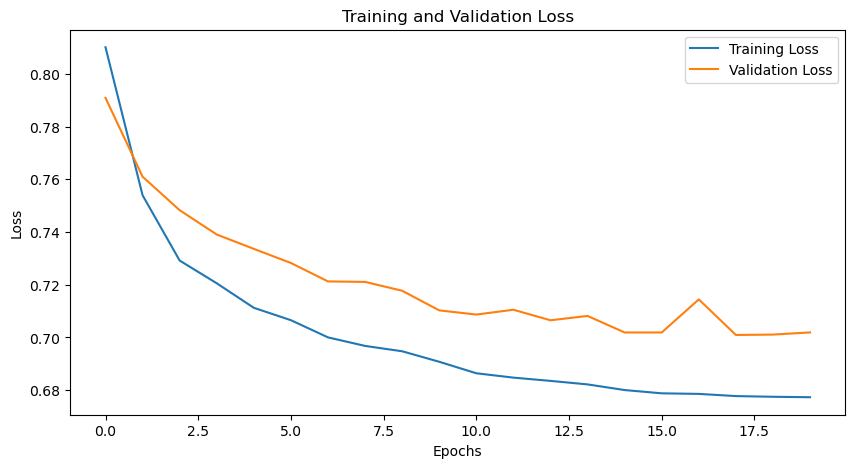

In [16]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [28]:
# Choose a sample by index
sample_index = 0  # Change this index to test other samples
sample = X.iloc[sample_index]
actual_label = y.iloc[sample_index]  # Get the actual label (0 = Normal, 1 = Anomaly)
# Scale the sample
sample_scaled = scaler.transform([sample])
# Reconstruct the sample using the autoencoder
reconstructed_sample = autoencoder.predict(sample_scaled)
# Calculate the reconstruction error
reconstruction_error = np.mean(np.power(sample_scaled - reconstructed_sample, 2))
# Determine if it's an anomaly based on the threshold
is_anomaly = reconstruction_error > threshold
# Display the results
print(f"Actual: {'Anomaly' if actual_label == 1 else 'Normal'}")
print(f"Predicted: {'Anomaly' if is_anomaly else 'Normal'}")
print(f"Reconstruction Error: {reconstruction_error:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Actual: Normal
Predicted: Normal
Reconstruction Error: 0.2725


C:\Users\Alok\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
